<a href="https://colab.research.google.com/github/Stroded4ever/MQP/blob/main/Combined_vol.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Project - Multi-Exchange GARCH(1,1) Model

Running GARCH(1,1) for S&P 500 (US) (^GSPC)
------------------------------------------------------------


[*********************100%***********************]  1 of 1 completed


  ω (omega): 3.191810e-06
  α (alpha): 0.0500
  β (beta):  0.9000
  Long-term σ: 0.0080
  Max Log-Likelihood: 9138.28

Running GARCH(1,1) for Euronext Paris (CAC 40) (^FCHI)
------------------------------------------------------------


[*********************100%***********************]  1 of 1 completed


  ω (omega): 4.681409e-06
  α (alpha): 0.0500
  β (beta):  0.9000
  Long-term σ: 0.0097
  Max Log-Likelihood: 8925.22

Running GARCH(1,1) for Euronext Germany (DAX) (^GDAXI)
------------------------------------------------------------


[*********************100%***********************]  1 of 1 completed


  ω (omega): 4.992579e-06
  α (alpha): 0.0500
  β (beta):  0.9000
  Long-term σ: 0.0100
  Max Log-Likelihood: 8740.20

Running GARCH(1,1) for Shanghai Composite (000001.SS)
------------------------------------------------------------


[*********************100%***********************]  1 of 1 completed


  ω (omega): 4.984216e-06
  α (alpha): 0.0500
  β (beta):  0.9000
  Long-term σ: 0.0100
  Max Log-Likelihood: 8314.75

Running GARCH(1,1) for Nikkei 225 (Japan) (^N225)
------------------------------------------------------------


[*********************100%***********************]  1 of 1 completed


  ω (omega): 6.474442e-06
  α (alpha): 0.0500
  β (beta):  0.9000
  Long-term σ: 0.0114
  Max Log-Likelihood: 8138.42


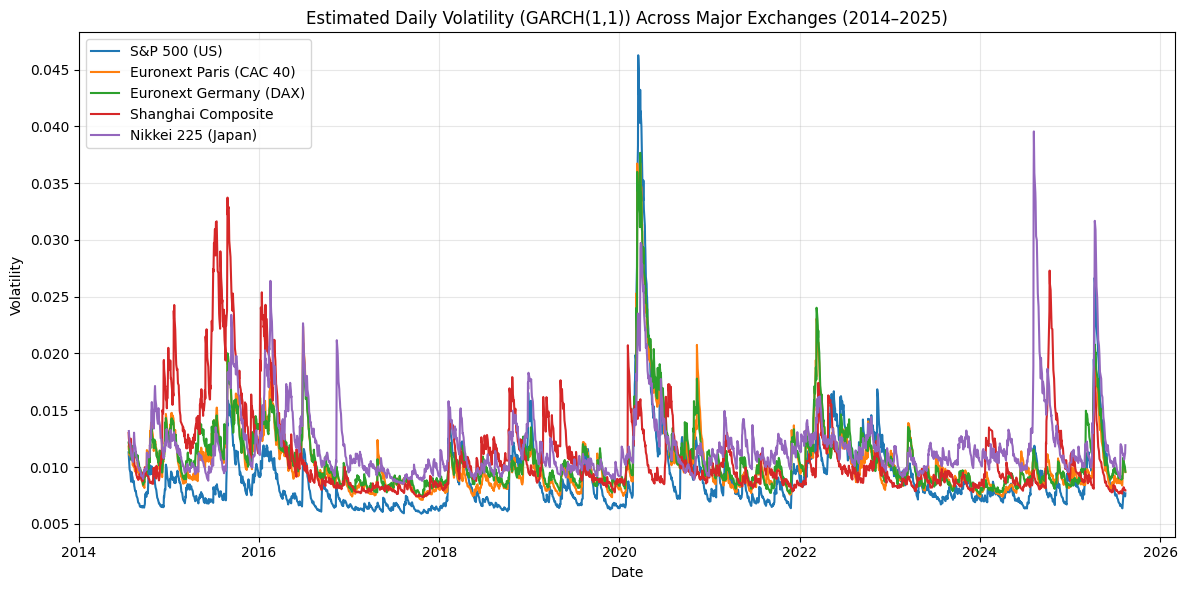

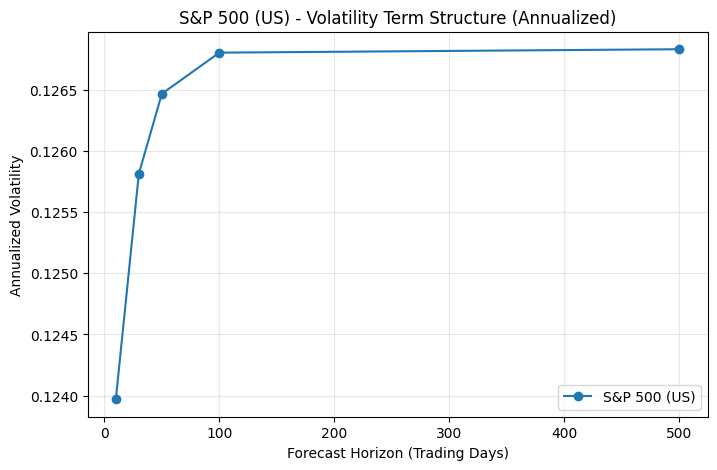

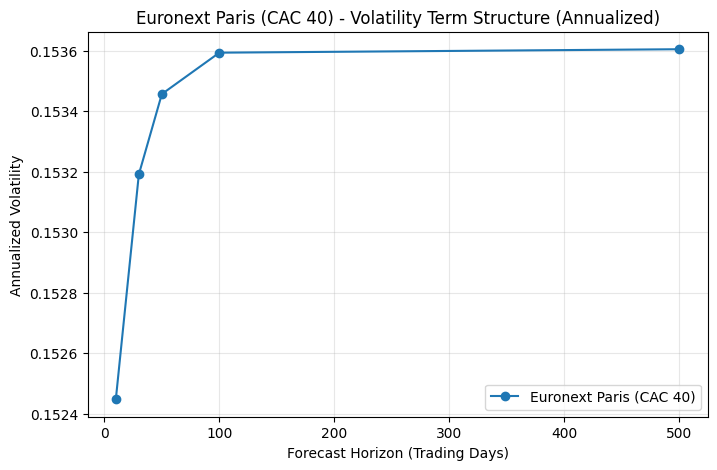

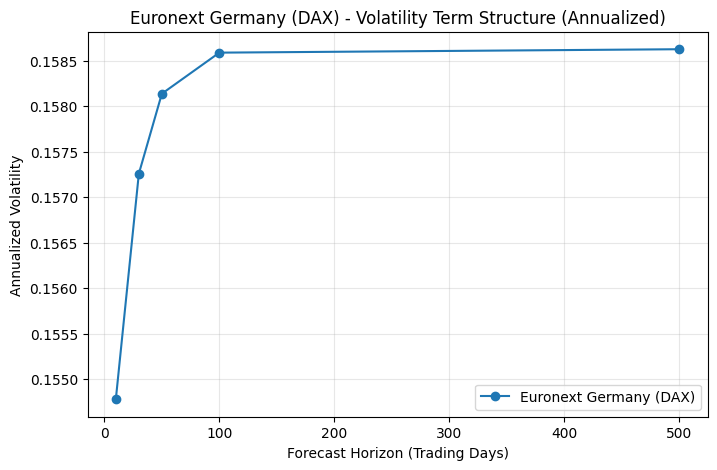

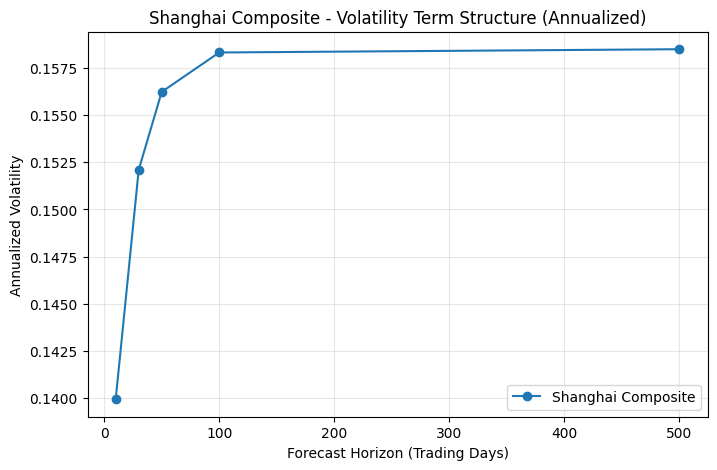

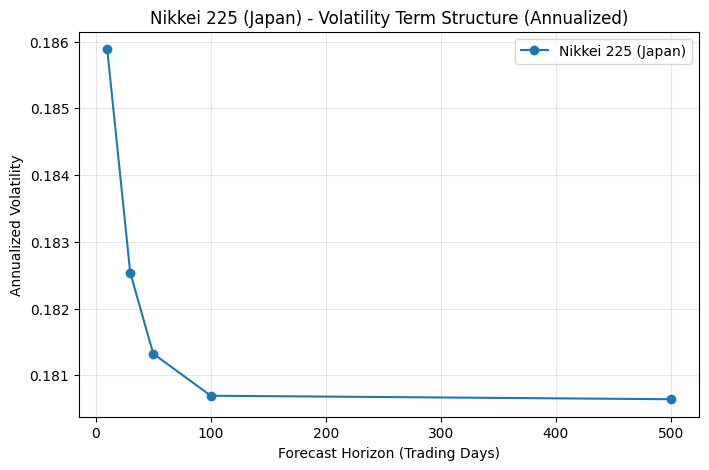


Summary of GARCH(1,1) Parameter Estimates Across Exchanges:


,Market,Ticker,Omega,Alpha,Beta,Long-term σ,Max Log-Likelihood
0,S&P 500 (US),^GSPC,0.000003,0.05,0.9,0.007990,9138.278295
1,Euronext Paris (CAC 40),^FCHI,0.000005,0.05,0.9,0.009676,8925.217579
2,Euronext Germany (DAX),^GDAXI,0.000005,0.05,0.9,0.009993,8740.200490
3,Shanghai Composite,000001.SS,0.000005,0.05,0.9,0.009984,8314.748169
4,Nikkei 225 (Japan),^N225,0.000006,0.05,0.9,0.011379,8138.421113


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from scipy.optimize import minimize
import warnings
from IPython.display import display
import yfinance as yf

# Suppress warnings
warnings.filterwarnings('ignore')
np.seterr(all='ignore')
np.random.seed(42)

print("Project - Multi-Exchange GARCH(1,1) Model")
print("=" * 60)

# ==========================================
# Exchange tickers (Yahoo Finance)
# ==========================================
# S&P 500 (US)              -> ^GSPC
# CAC 40 (Euronext Paris)   -> ^FCHI
# DAX (Euronext Germany)    -> ^GDAXI
# Shanghai Composite        -> 000001.SS
# Nikkei 225 (Japan)        -> ^N225
# FTSE 100 (UK)            -> ^FTSE
# NIFTY 50 (India)         -> ^NSEI
# Hang Seng (Hong Kong)    -> ^HSI
# ==========================================

exchanges = {
    "S&P 500 (US)": "^GSPC",
    "Euronext Paris (CAC 40)": "^FCHI",
    "Euronext Germany (DAX)": "^GDAXI",
    "Shanghai Composite": "000001.SS",
    "Nikkei 225 (Japan)": "^N225",
    "FTSE 100 (UK)":"^FTSE",
    "NIFTY 50 (India)":"^NSEI",
    "Hang Seng (Hong Kong)":"^HSI"
}

start_date = "2014-07-18"
end_date   = "2025-08-14"

# ==========================================
# GARCH(1,1) log-likelihood
# ==========================================
def garch_loglik(params, data):
    omega, alpha, beta = params
    if omega <= 0 or alpha < 0 or beta < 0 or alpha + beta >= 1:
        return 1e10
    n = len(data)
    sigma2 = np.zeros(n)
    sigma2[0] = np.var(data)
    for t in range(1, n):
        sigma2[t] = omega + alpha * data[t-1]**2 + beta * sigma2[t-1]
    ll = -0.5 * np.sum(np.log(2*np.pi) + np.log(sigma2) + data**2 / sigma2)
    return -ll

# ==========================================
# Run GARCH(1,1) for a given ticker
# ==========================================
def run_garch(name, ticker):
    print(f"\nRunning GARCH(1,1) for {name} ({ticker})")
    print("-" * 60)

    # Download prices
    data = yf.download(ticker, start=start_date, end=end_date)
    close_prices = data['Close'].dropna()
    if close_prices.empty:
        print(f"No data found for {ticker}, skipping...")
        return None

    S = close_prices.to_numpy().flatten()
    dates = close_prices.index
    returns = np.diff(np.log(S))

    # Estimate parameters
    init_params = [0.000001, 0.05, 0.9]
    bounds = [(1e-12, None), (0.0, 1.0), (0.0, 1.0)]
    res = minimize(garch_loglik, init_params, args=(returns,), bounds=bounds)
    omega, alpha, beta = res.x
    max_loglik = -res.fun

    # Conditional variance
    sigma2 = np.zeros_like(returns)
    sigma2[0] = np.var(returns)
    for t in range(1, len(returns)):
        sigma2[t] = omega + alpha * returns[t-1]**2 + beta * sigma2[t-1]
    cond_vol = np.sqrt(sigma2)

    uncond_vol = math.sqrt(omega / (1 - alpha - beta))

    print(f"  ω (omega): {omega:.6e}")
    print(f"  α (alpha): {alpha:.4f}")
    print(f"  β (beta):  {beta:.4f}")
    print(f"  Long-term σ: {uncond_vol:.4f}")
    print(f"  Max Log-Likelihood: {max_loglik:.2f}")

    return {
        "Market": name,
        "Ticker": ticker,
        "Dates": dates[1:],  # skip first return
        "Volatility": cond_vol,
        "Omega": omega,
        "Alpha": alpha,
        "Beta": beta,
        "Long-term σ": uncond_vol,
        "Max Log-Likelihood": max_loglik
    }

# ==========================================
# Run GARCH across all exchanges
# ==========================================
results = []
for name, ticker in exchanges.items():
    res = run_garch(name, ticker)
    if res:
        results.append(res)

# ==========================================
# Combined volatility plot
# ==========================================
plt.figure(figsize=(12, 6))
for res in results:
    plt.plot(res["Dates"], res["Volatility"], label=res["Market"])
plt.title("Estimated Daily Volatility (GARCH(1,1)) Across Major Exchanges (2014–2025)")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# ==========================================
# Term Structure (per market)
# ==========================================
horizons = np.array([10, 30, 50, 100, 500])
for res in results:
    omega, alpha, beta = res["Omega"], res["Alpha"], res["Beta"]
    sigma2_last = res["Volatility"][-1]**2
    Vl = omega / (1 - alpha - beta)

    term_vol = []
    for h in horizons:
        sigma2_h = Vl + (alpha + beta)**h * (sigma2_last - Vl)
        sigma_h = math.sqrt(sigma2_h)
        sigma_annual = sigma_h * math.sqrt(252)
        term_vol.append(sigma_annual)

    plt.figure(figsize=(8,5))
    plt.plot(horizons, term_vol, marker="o", linestyle="-", label=res["Market"])
    plt.title(f"{res['Market']} - Volatility Term Structure (Annualized)")
    plt.xlabel("Forecast Horizon (Trading Days)")
    plt.ylabel("Annualized Volatility")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

# ==========================================
# Summary Table
# ==========================================
summary_df = pd.DataFrame({
    "Market": [r["Market"] for r in results],
    "Ticker": [r["Ticker"] for r in results],
    "Omega": [r["Omega"] for r in results],
    "Alpha": [r["Alpha"] for r in results],
    "Beta": [r["Beta"] for r in results],
    "Long-term σ": [r["Long-term σ"] for r in results],
    "Max Log-Likelihood": [r["Max Log-Likelihood"] for r in results]
})

print("\nSummary of GARCH(1,1) Parameter Estimates Across Exchanges:")
display(summary_df)